In [1]:
# Incase we have to clear all variables
%reset -f

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt


import time
import heatmap_setup as hm
import numpy as np


from SES_setup import *
from utils import *
from style import *
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061'][::-1]
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 'large'

def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array


def heatmap_plotter(num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', ylim=False):
    
    # If ss_info_params list is provided, then makes heatmap from memory not disk
    
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        ss_array_add, PARAMS, info_array_add = heatmap_loader(num, dir_name=dir_name+'_add')
        data = {'non-add.': [ss_array,'solid'], 'add.': [ss_array_add, 'dashed']}
    info = info_array[0][0]
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    #print info
    
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=8000.)
    eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for key in data.keys():
        if observable=='DS/GS':
            ss_arrayGS = steadystate_observable(data[key][0], PARAMS, 'OO')
            ss_arrayDS = steadystate_observable(data[key][0], PARAMS, 'dark')
            ss_arrayBS = steadystate_observable(data[key][0], PARAMS, 'bright')
            ss_array = (ss_arrayDS+ss_arrayBS)/ss_arrayGS
        else:
            ss_array = steadystate_observable(data[key][0], PARAMS, observable)
        
        ylab = ' = '.join(["$"+l+"$" for l in PARAMS['y_axis_parameters']])
        for i, y_val in enumerate(PARAMS['y_values']):
            x_values = PARAMS['x_values']

            lbl = ylab+"="+"{:0.1f}".format(y_val)
            if key == 'add.':
                lbl = None
            axes.plot(x_values, ss_array[i], label=lbl, 
                      linestyle=data[key][1], color=colourWheel[i*8])
            
        if print_params:
            print_PARAMS(PARAMS)
        labs = ("$\\"+l+"$" for l in PARAMS['x_axis_parameters'])
        xlab = ' , '.join(labs)
        
        plt.xlabel(xlab+" (cm$^{-1}$)")
        #plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
        try:
            plt.ylabel(r"Steadystate "+make_expectation_labels()[observable])
        except:
            plt.ylabel(r"Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    #plt.grid()
    plt.xlim(x_values[0], x_values[-1])
    if ylim:
        plt.ylim(ylim[0], ylim[-1])
    plot_filename = 'PLOTS/'+dir_name+'_'+observable+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename,bbox_inches='tight')
    plt.show()
    print "saved at {}".format(plot_filename)

# Example of loading data to memory
"""ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x')"""

SES_setup loaded globally


'ss_info_params = [ss_array, info_array, PARAMS]\n\nheatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,\n                print_params=False, observable=\'sigma_x\')\nheatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",\n                print_params=False, observable=\'sigma_x\')'

# Environments with different parity $\alpha_1 = -\alpha_2$

/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


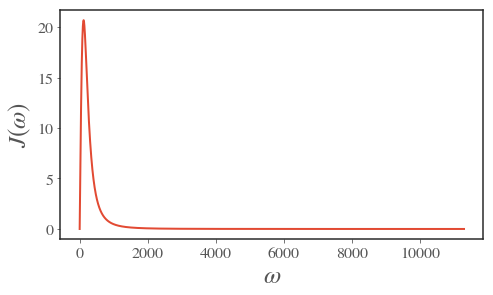

Gap is 180.350062725. Phonon thermal energy is 208.5. Phonon SD peak is 115.01150115. N=7.
[  1.00000000e-02   2.78255940e-02   7.74263683e-02   2.15443469e-01
   5.99484250e-01   1.66810054e+00   4.64158883e+00   1.29154967e+01
   3.59381366e+01   1.00000000e+02]
Steady state for 2 took 0.016 seconds with direct, OO changed by 2700.3104%
Steady state for 3 took 0.034 seconds with direct, OO changed by 4.5314%
Steady state for 4 took 0.070 seconds with direct, OO changed by 0.2060%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.004 seconds with direct, OO changed by 134.8082%
Steady state for 3 took 0.018 seconds with direct, OO changed by 0.7871%
Steady state for 4 took 0.084 seconds with direct, OO changed by 0.0382%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.006 seconds with direct, OO changed by 38.8396%
Steady state for 3 took 0.017 seconds with direct, OO changed by 0.2345%
Steady state for 4 took 0.084 seconds with direct, OO changed b

Steady state for 3 took 0.018 seconds with direct, OO changed by 0.3462%
Steady state for 4 took 0.086 seconds with direct, OO changed by 0.0239%
calculation converged - 4.6, 77.0 (7/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 1409.9990%
Steady state for 3 took 0.017 seconds with direct, OO changed by 1.3219%
Steady state for 4 took 0.086 seconds with direct, OO changed by 0.1456%
Steady state for 5 took 0.485 seconds with direct, OO changed by 0.0122%
calculation converged - 12.9, 77.0 (8/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 44.9028%
Steady state for 3 took 0.031 seconds with direct, OO changed by 4.0030%
Steady state for 4 took 0.113 seconds with direct, OO changed by 0.7836%
Steady state for 5 took 0.477 seconds with direct, OO changed by 0.1202%
Steady state for 6 took 2.631 seconds with direct, OO changed by 0.0148%
calculation converged - 35.9, 77.0 (9/20)
Steady state for 2 took 0.004 seconds with direct, OO changed by 17.

"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name=dirname, save_data=True,\n                            persistent=False, method='direct', threshold=1e-9, \n                            conv_percent_tol=0.025, conv_obs='OO', additive=False)"

In [3]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N, parity_flip=True)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_phased'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)"""
#DATA/heatmap_TphvAlpha_phased_2

plotting in new style


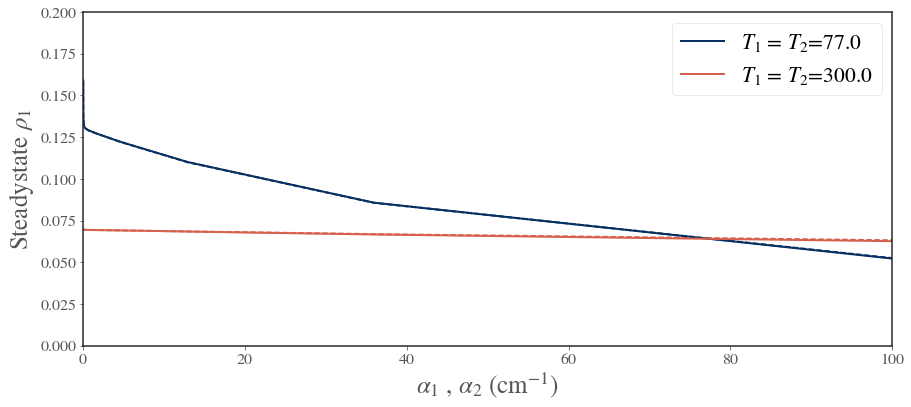

saved at PLOTS/heatmap_TphvAlpha_phased_XO_3.pdf
plotting in new style


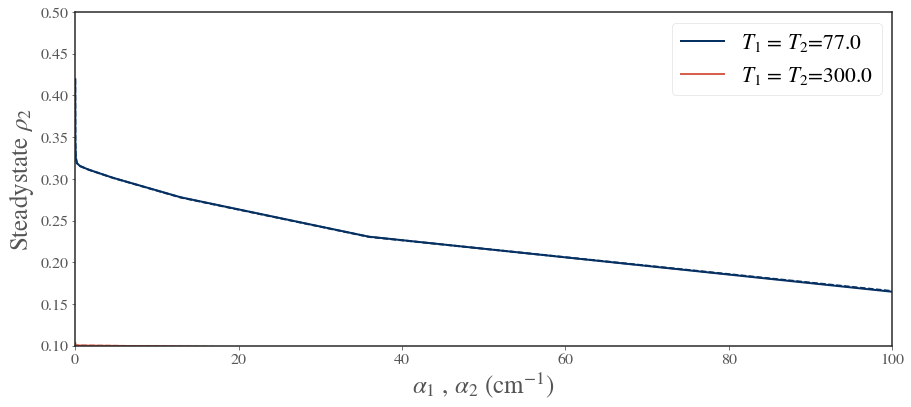

saved at PLOTS/heatmap_TphvAlpha_phased_OX_3.pdf
plotting in new style


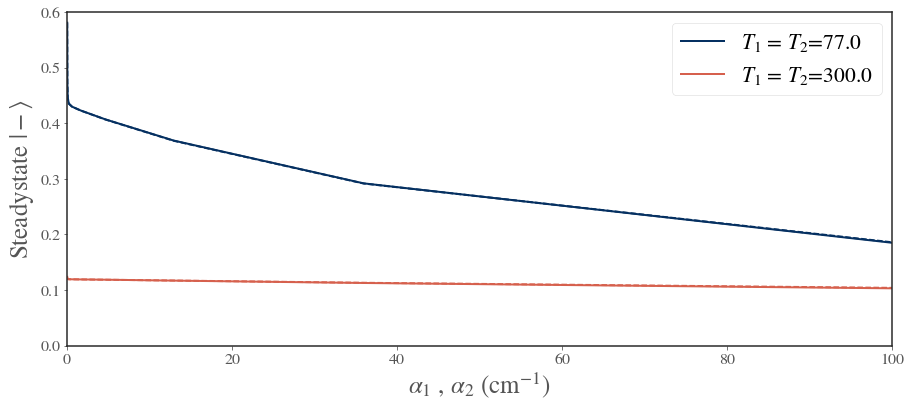

saved at PLOTS/heatmap_TphvAlpha_phased_dark_3.pdf
plotting in new style


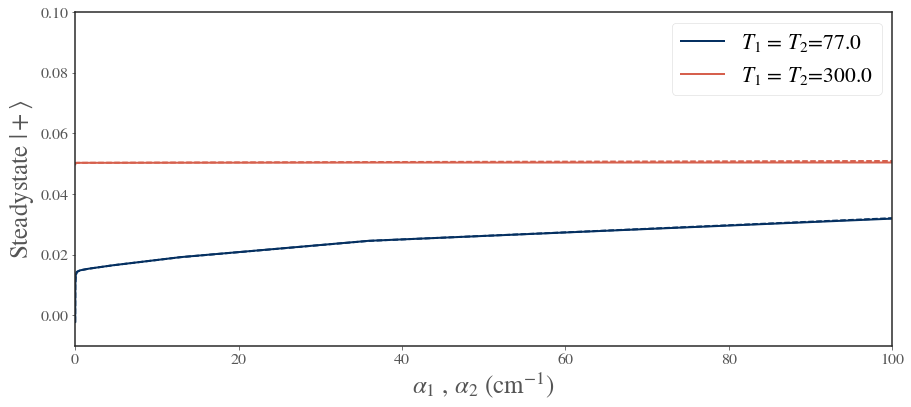

saved at PLOTS/heatmap_TphvAlpha_phased_bright_3.pdf
plotting in new style


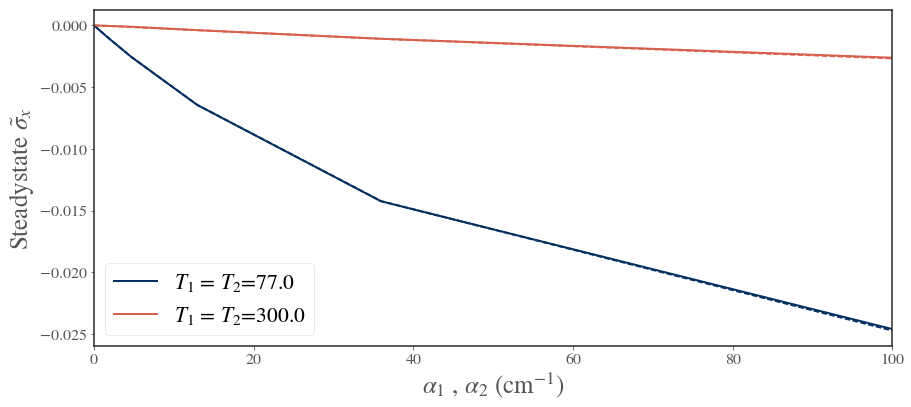

saved at PLOTS/heatmap_TphvAlpha_phased_eig_x_3.pdf


In [12]:
num=3
dirname = 'heatmap_TphvAlpha_phased'
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO', ylim=[0,0.2])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX', ylim=[0.1,0.5])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark', ylim=[0,0.6])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright', ylim=[-0.01,0.1])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

Okay, we want to know:
- What is the nature of the coherence we are seeing?
    - How does site coherence and population inversion relate to exciton coherence?


### Uncoupled monomers

These get updated dynamically by the various functions. `SES_setup.PARAMS_setup` just imposes the relevant symmetry behind the scenes so the API is clean and so that we can reuse code for dimer case - e.g. $\alpha_1 = \alpha_2$, no doubly excited state.

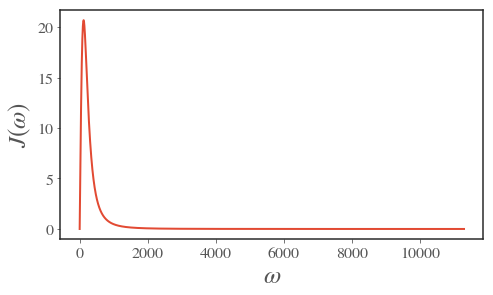

Gap is 161.31. Phonon thermal energy is 208.5. Phonon SD peak is 115.01150115. N=7.
[  1.00000000e-02   2.78255940e-02   7.74263683e-02   2.15443469e-01
   5.99484250e-01   1.66810054e+00   4.64158883e+00   1.29154967e+01
   3.59381366e+01   1.00000000e+02]
Steady state for 2 took 0.003 seconds with direct, OO changed by 41.4594%
Steady state for 3 took 0.007 seconds with direct, OO changed by 0.0000%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.002 seconds with direct, OO changed by 102.3899%
Steady state for 3 took 0.007 seconds with direct, OO changed by 0.0000%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.002 seconds with direct, OO changed by 121.9526%
Steady state for 3 took 0.007 seconds with direct, OO changed by 0.0000%
calculation converged - 0.1, 77.0 (3/20)
Steady state for 2 took 0.005 seconds with direct, OO changed by 55.5162%
Steady state for 3 took 0.006 seconds with direct, OO changed by 0.0000%
calculation converged - 0.2, 

Steady state for 3 took 0.011 seconds with direct, OO changed by 0.0564%
Steady state for 4 took 0.092 seconds with direct, OO changed by 0.0385%
Steady state for 5 took 0.346 seconds with direct, OO changed by 0.0261%
Steady state for 6 took 1.404 seconds with direct, OO changed by 0.0172%
Steady state for 7 took 9.444 seconds with direct, OO changed by 0.0110%
Steady state for 8 took 38.121 seconds with direct, OO changed by 0.0068%
calculation converged - 100.0, 300.0 (20/20)
Files saved at DATA/heatmap_TphvAlpha_uncoupled_7


"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name=dirname, save_data=True,\n                            persistent=False, method='direct', threshold=1e-12, \n                            conv_percent_tol=0.01, conv_obs='OO', additive=False)\n"

In [4]:

w_2 = 1.4*ev_to_inv_cm
bias = 0.02*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.0*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_uncoupled'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.01, conv_obs='OO', additive=False)
"""
#DATA/heatmap_TphvAlpha_uncoupled_6

plotting in new style


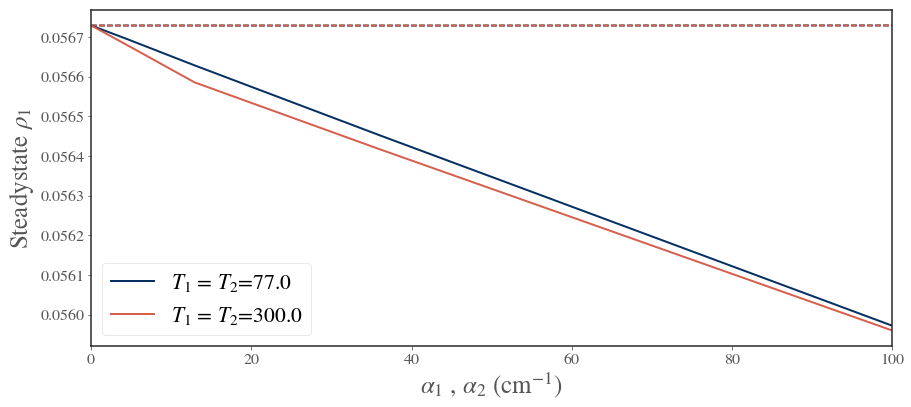

saved at PLOTS/heatmap_TphvAlpha_uncoupled_XO_7.pdf
plotting in new style


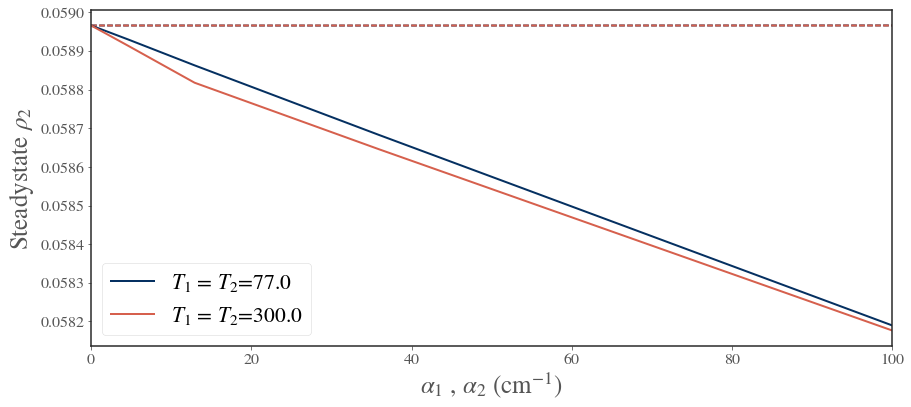

saved at PLOTS/heatmap_TphvAlpha_uncoupled_OX_7.pdf


In [13]:
num=7
dirname = 'heatmap_TphvAlpha_uncoupled'
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

In [ ]:
H, L = get_H_and_L(PARAMS)


In [ ]:
eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
print (2*PARAMS['V']/eta)
print (PARAMS['bias']/eta)
print (1/np.sqrt(2))

In [ ]:
np.linspace(200, 600, 5, endpoint=False)

In [ ]:
np.log(0.0001)
np.logspace(-5, 2, 10, endpoint=False)

## Heterodimer
Shouldn't increasing the phonon coupling strength lead to suppression of ground state population?

In [4]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias=0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)

"""

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name='heatmap_TphvAlpha', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='OO')
"""
dirname = 'heatmap_TphvAlpha_hetero'

[  1.00000000e-02   2.78255940e-02   7.74263683e-02   2.15443469e-01
   5.99484250e-01   1.66810054e+00   4.64158883e+00   1.29154967e+01
   3.59381366e+01   1.00000000e+02]


In [ ]:
ss_array, PARAMS, info_array = heatmap_loader(16, dir_name="heatmap_TphvAlpha")
print zip(PARAMS['x_values'], steadystate_observable(ss_array, PARAMS, 'OO')[0])

In [5]:

reload(hm)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

Steady state for 2 took 0.003 seconds with direct, OO changed by 26.1723%
Steady state for 3 took 0.016 seconds with direct, OO changed by 4.5313%
Steady state for 4 took 0.078 seconds with direct, OO changed by 0.2060%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 14.6765%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.7871%
Steady state for 4 took 0.081 seconds with direct, OO changed by 0.0382%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 546.1702%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.2344%
Steady state for 4 took 0.080 seconds with direct, OO changed by 0.0115%
calculation converged - 0.1, 77.0 (3/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 156.1420%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.0876%
Steady state for 4 took 0.186 seconds with direct, OO changed by 0.0

Steady state for 5 took 0.377 seconds with direct, OO changed by 0.0126%
calculation converged - 12.9, 77.0 (8/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 13.7488%
Steady state for 3 took 0.013 seconds with direct, OO changed by 4.1209%
Steady state for 4 took 0.069 seconds with direct, OO changed by 0.8102%
Steady state for 5 took 0.374 seconds with direct, OO changed by 0.1252%
Steady state for 6 took 2.036 seconds with direct, OO changed by 0.0155%
calculation converged - 35.9, 77.0 (9/20)
Steady state for 2 took 0.004 seconds with direct, OO changed by 44.6996%
Steady state for 3 took 0.014 seconds with direct, OO changed by 7.6034%
Steady state for 4 took 0.065 seconds with direct, OO changed by 2.3398%
Steady state for 5 took 0.343 seconds with direct, OO changed by 0.7118%
Steady state for 6 took 2.113 seconds with direct, OO changed by 0.1886%
Steady state for 7 took 8.491 seconds with direct, OO changed by 0.0419%
Steady state for 8 took 40.126 seconds

plotting in new style


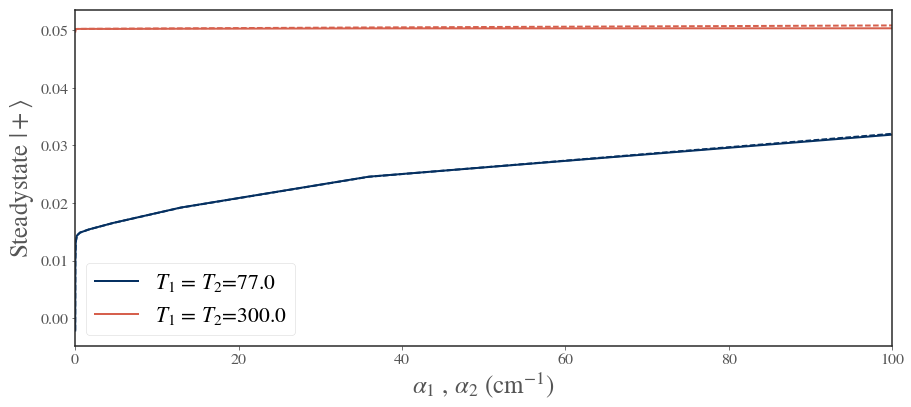

saved at PLOTS/heatmap_TphvAlpha_hetero_bright_5.pdf
plotting in new style


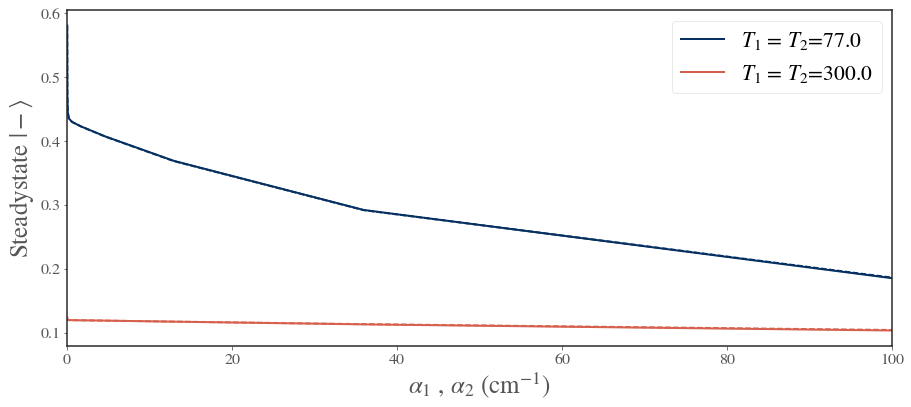

saved at PLOTS/heatmap_TphvAlpha_hetero_dark_5.pdf
plotting in new style


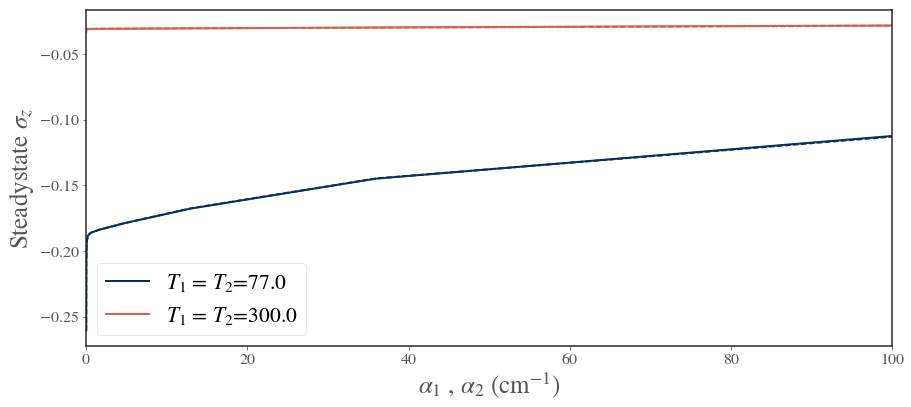

saved at PLOTS/heatmap_TphvAlpha_hetero_sigma_z_5.pdf
plotting in new style


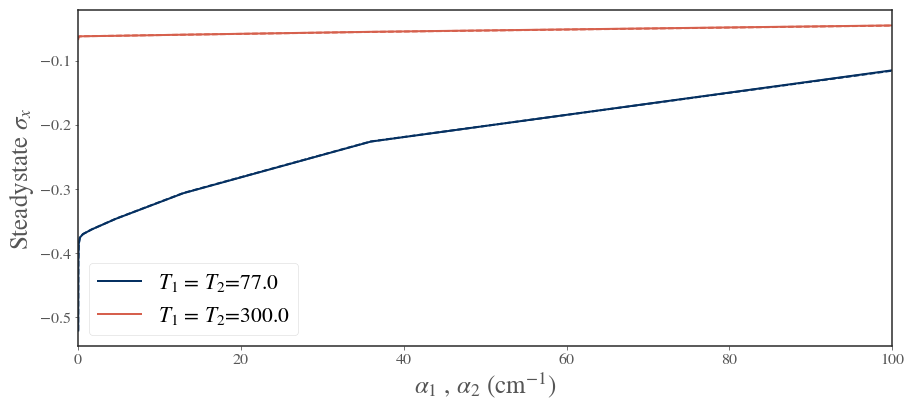

saved at PLOTS/heatmap_TphvAlpha_hetero_sigma_x_5.pdf
plotting in new style


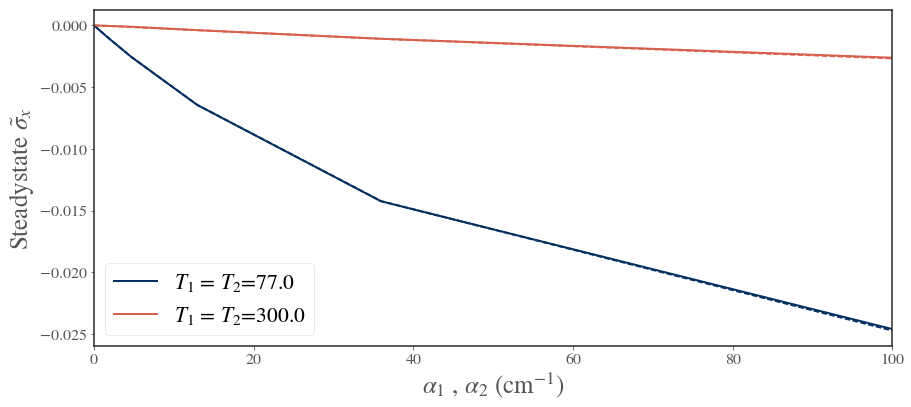

saved at PLOTS/heatmap_TphvAlpha_hetero_eig_x_5.pdf


In [14]:
dirname = 'heatmap_TphvAlpha_hetero'
num = 5
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

In [ ]:
num = 20
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='DS/GS')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
"""heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')"""




# Homodimer

In [7]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)


"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name='heatmap_TphvAlpha', save_data=True,\n                            persistent=False, method='direct', threshold=1e-12, \n                                              conv_percent_tol=0.001, conv_obs='OO')"

In [9]:
print inv_ps_to_inv_cm*10**(-3)
print w_0/ev_to_inv_cm
print Gamma/ev_to_inv_cm

0.005309
0.0247969747691
0.0495939495382


In [ ]:
print (x_values)

In [8]:
dirname = 'heatmap_TphvAlpha_homo'
reload(hm)

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=False)

"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)"""

Steady state for 2 took 0.003 seconds with direct, OO changed by 395.2671%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.0010%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 54.8966%
Steady state for 3 took 0.015 seconds with direct, OO changed by 0.0010%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.003 seconds with direct, OO changed by 33.7262%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.0010%
calculation converged - 0.0, 77.0 (3/20)
Steady state for 2 took 0.004 seconds with direct, OO changed by 53.1423%
Steady state for 3 took 0.015 seconds with direct, OO changed by 0.0012%
calculation converged - 0.0, 77.0 (4/20)
Steady state for 2 took 0.011 seconds with direct, OO changed by 77.4063%
Steady state for 3 took 0.015 seconds with direct, OO changed by 0.0022%
calculation converged - 0.0, 77.0 (5/20)
Steady state for 2 took 0.003 seconds with direct, OO chang

Steady state for 8 took 36.121 seconds with direct, OO changed by 0.0362%
calculation converged - 100.0, 300.0 (20/20)
Files saved at DATA/heatmap_TphvAlpha_homo_add_3


plotting in new style


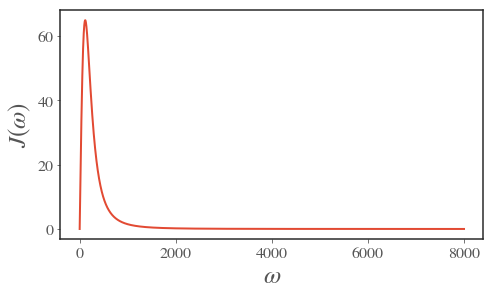

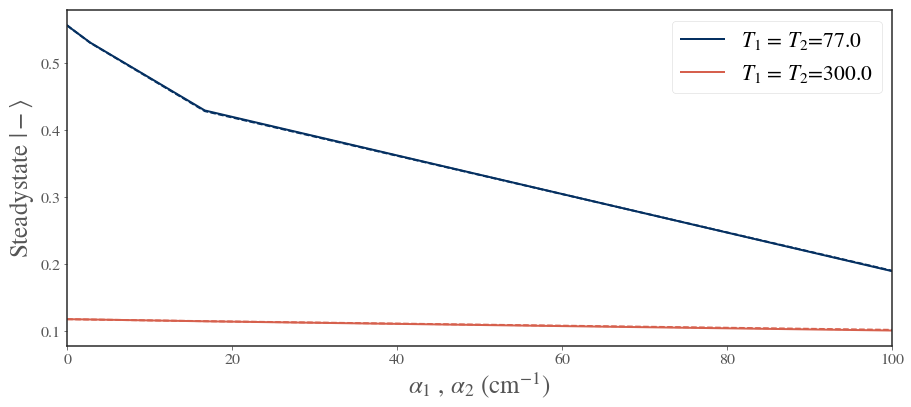

saved at PLOTS/heatmap_TphvAlpha_homo_dark_3.pdf
plotting in new style


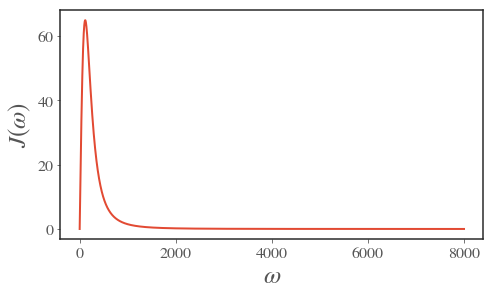

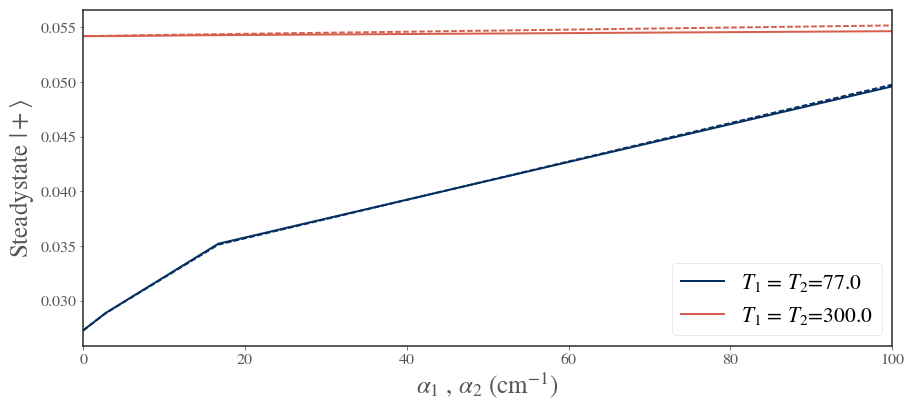

saved at PLOTS/heatmap_TphvAlpha_homo_bright_3.pdf
plotting in new style


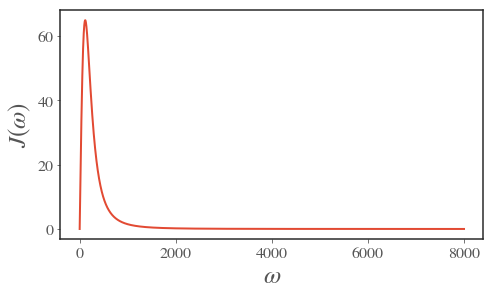

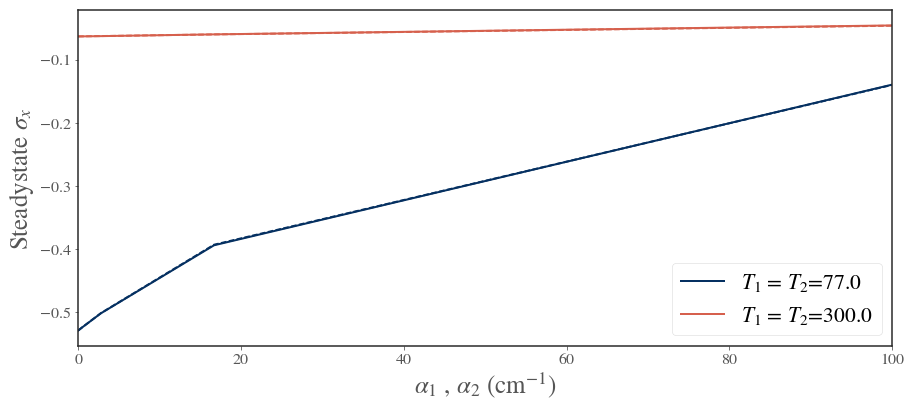

saved at PLOTS/heatmap_TphvAlpha_homo_sigma_x_3.pdf


In [17]:
def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array

dirname = 'heatmap_TphvAlpha_homo'
num = 3
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='XO')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='dark')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='bright')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='sigma_x')


In [15]:
num = 3
dirname = 'heatmap_TphvAlpha_homo'
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_y')

IOError: [Errno 2] No such file or directory: 'DATA/heatmap_TphvAlpha_add_3/ss_array.pickle'

In [ ]:
num = 1
dir_name = 'heatmap_TphvAlpha_a19'
hm = heatmap_loader(19, dir_name='heatmap_TphvAlpha')
hm2 = heatmap_loader(1, dir_name='heatmap_TphvAlpha_a19')
print hm[0]
"""heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_y')"""

# Asymmetrical phonon environments

In [20]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 5.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 20, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = "heatmap_TphvAlpha_assymmetrical"
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO')
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

Steady state for 2 took 0.023 seconds with direct, OO changed by 2232.0999%
Steady state for 3 took 0.058 seconds with direct, OO changed by 0.4486%
Steady state for 4 took 0.339 seconds with direct, OO changed by 0.0322%
calculation converged - 0.0, 77.0 (1/40)
Steady state for 2 took 0.022 seconds with direct, OO changed by 49.7739%
Steady state for 3 took 0.071 seconds with direct, OO changed by 0.4488%
Steady state for 4 took 0.264 seconds with direct, OO changed by 0.0322%
calculation converged - 0.0, 77.0 (2/40)
Steady state for 2 took 0.008 seconds with direct, OO changed by 27.1433%
Steady state for 3 took 0.021 seconds with direct, OO changed by 0.4491%
Steady state for 4 took 0.197 seconds with direct, OO changed by 0.0322%
calculation converged - 0.0, 77.0 (3/40)
Steady state for 2 took 0.028 seconds with direct, OO changed by 49.8481%
Steady state for 3 took 0.063 seconds with direct, OO changed by 0.4496%
Steady state for 4 took 0.205 seconds with direct, OO changed by 0.0

Steady state for 2 took 0.006 seconds with direct, OO changed by 69.5449%
Steady state for 3 took 0.037 seconds with direct, OO changed by 0.0130%
calculation converged - 0.8, 300.0 (30/40)
Steady state for 2 took 0.003 seconds with direct, OO changed by 152.4147%
Steady state for 3 took 0.042 seconds with direct, OO changed by 0.0140%
calculation converged - 1.3, 300.0 (31/40)
Steady state for 2 took 0.006 seconds with direct, OO changed by 3.3427%
Steady state for 3 took 0.026 seconds with direct, OO changed by 0.0158%
calculation converged - 2.1, 300.0 (32/40)
Steady state for 2 took 0.007 seconds with direct, OO changed by 47.9418%
Steady state for 3 took 0.019 seconds with direct, OO changed by 0.0186%
calculation converged - 3.4, 300.0 (33/40)
Steady state for 2 took 0.007 seconds with direct, OO changed by 173.6270%
Steady state for 3 took 0.016 seconds with direct, OO changed by 0.0231%
calculation converged - 5.5, 300.0 (34/40)
Steady state for 2 took 0.004 seconds with direct

Steady state for 4 took 0.234 seconds with direct, OO changed by 39.5456%
Steady state for 5 took 1.049 seconds with direct, OO changed by 0.0066%
calculation converged - 2.1, 300.0 (32/40)
Steady state for 4 took 0.197 seconds with direct, OO changed by 146.4352%
Steady state for 5 took 0.928 seconds with direct, OO changed by 0.0078%
calculation converged - 3.4, 300.0 (33/40)
Steady state for 4 took 0.164 seconds with direct, OO changed by 14.6521%
Steady state for 5 took 1.092 seconds with direct, OO changed by 0.0098%
calculation converged - 5.5, 300.0 (34/40)
Steady state for 4 took 0.131 seconds with direct, OO changed by 155.7624%
Steady state for 5 took 0.955 seconds with direct, OO changed by 0.0129%
calculation converged - 8.9, 300.0 (35/40)
Steady state for 4 took 0.147 seconds with direct, OO changed by 17.4455%
Steady state for 5 took 0.775 seconds with direct, OO changed by 0.0180%
calculation converged - 14.4, 300.0 (36/40)
Steady state for 4 took 0.288 seconds with dire

plotting in new style


/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


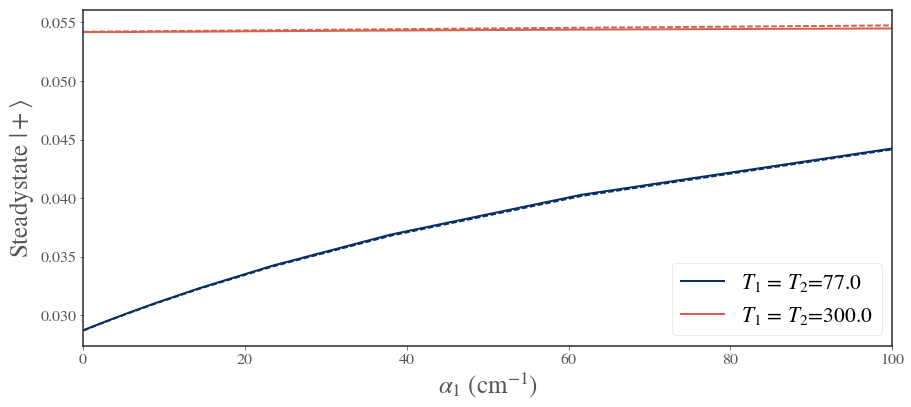

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_bright_1.pdf
plotting in new style


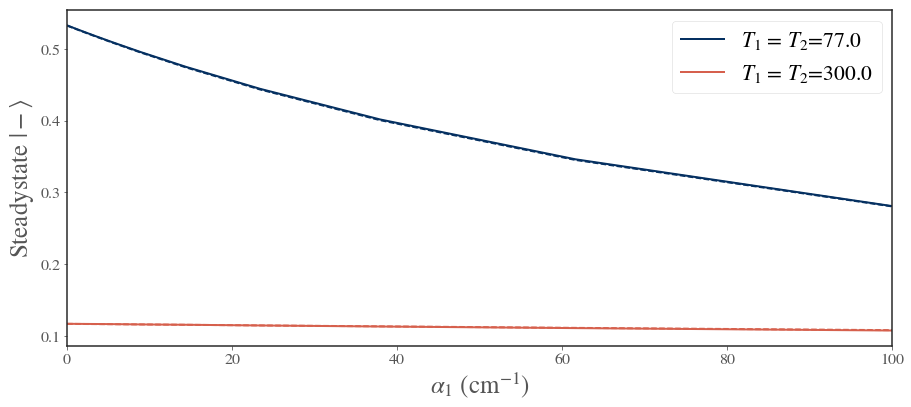

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_dark_1.pdf
plotting in new style


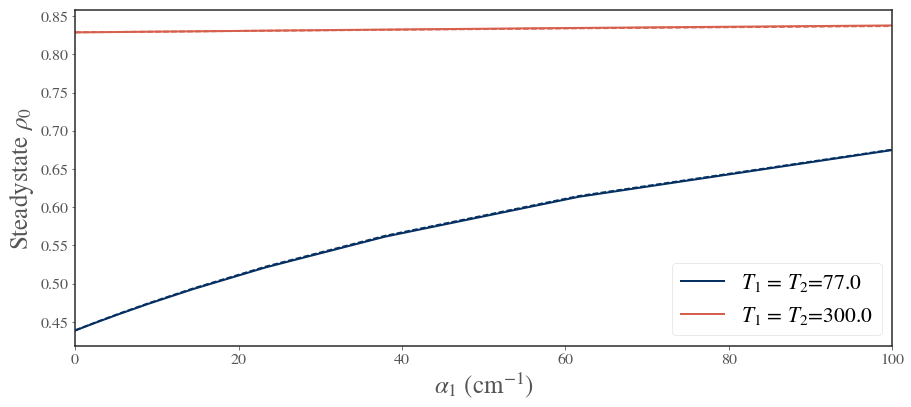

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_OO_1.pdf
plotting in new style


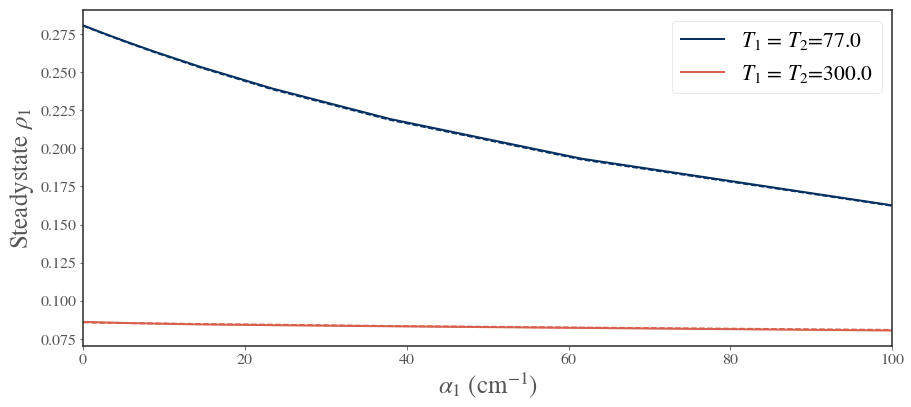

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_XO_1.pdf
plotting in new style


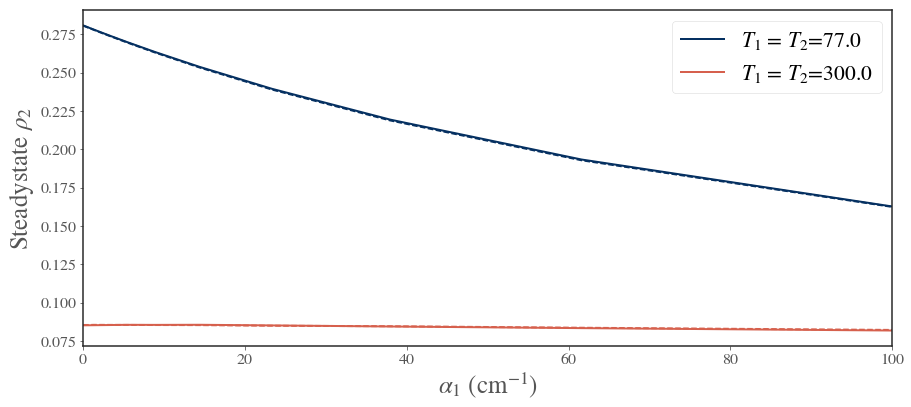

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_OX_1.pdf
plotting in new style


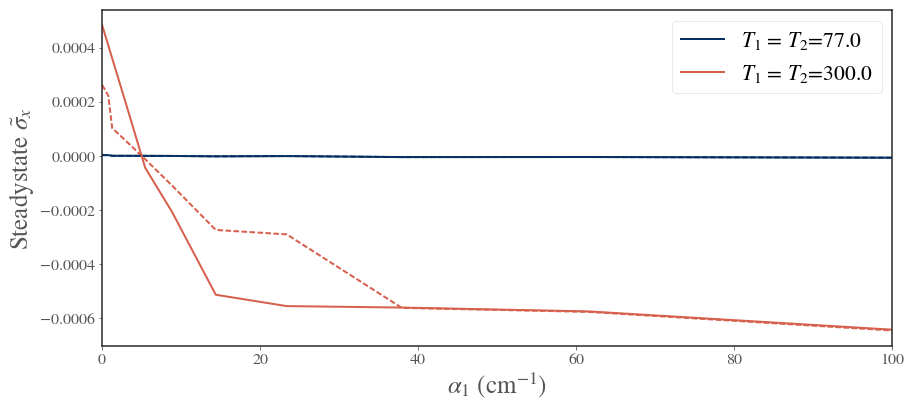

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_x_1.pdf
plotting in new style


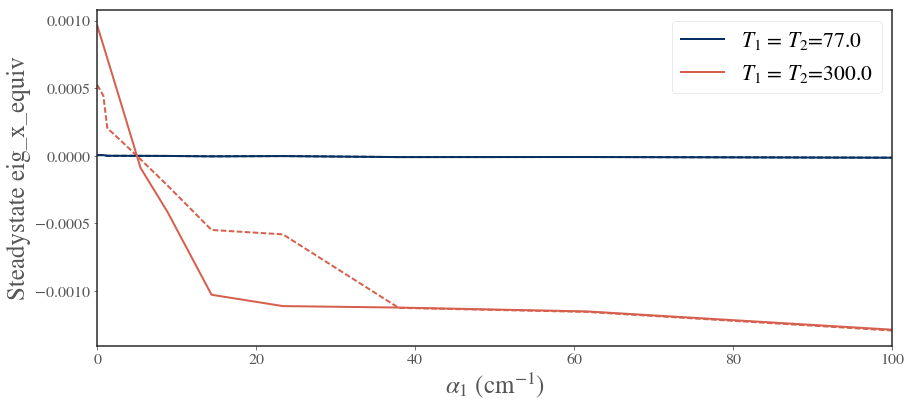

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_x_equiv_1.pdf
plotting in new style


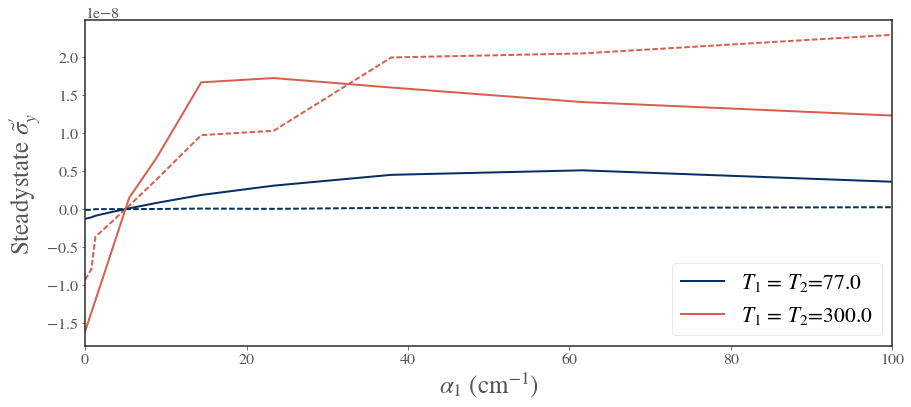

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_y_1.pdf
plotting in new style


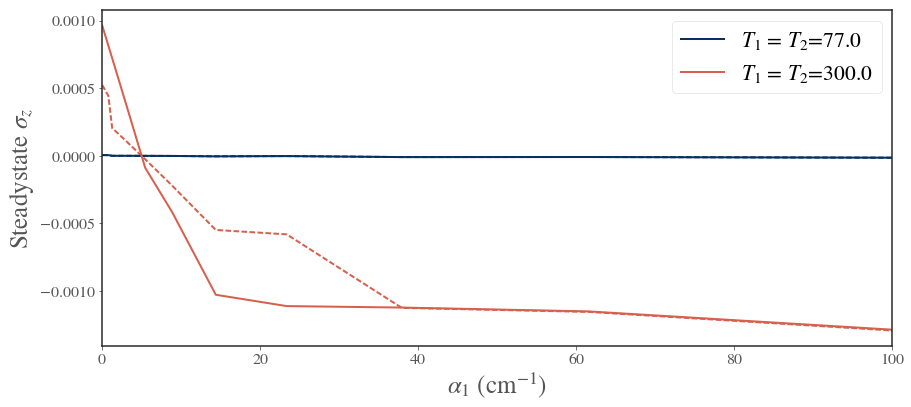

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_z_1.pdf
plotting in new style


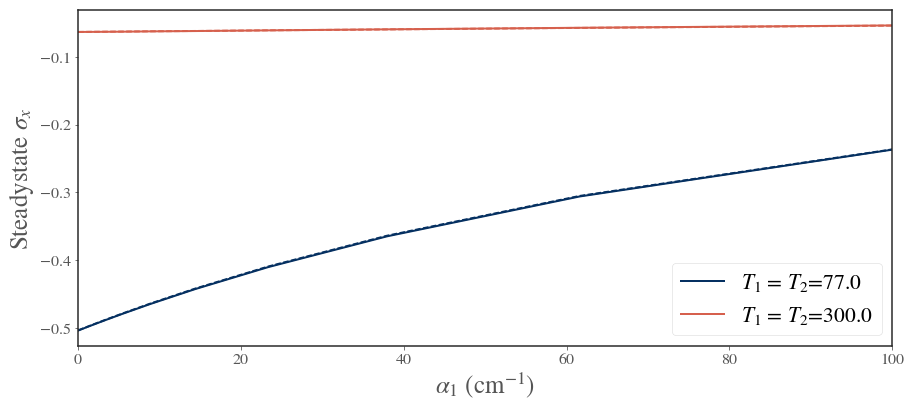

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_x_1.pdf
plotting in new style


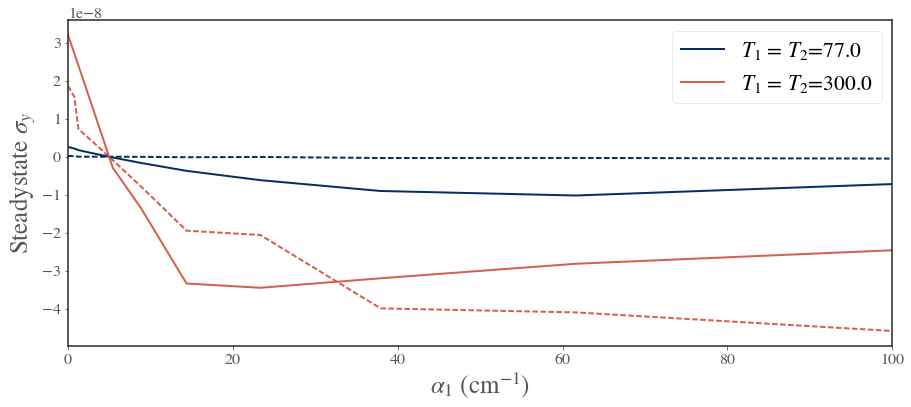

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_y_1.pdf


In [21]:
num = 1
dirname = "heatmap_TphvAlpha_assymmetrical"
#heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
#                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_y')

# Plotting T vs $\alpha$ 

In [ ]:
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x')
"""heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')"""
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OO')
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='XO')
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OX')
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_z')
heatmap_plotter(num=2, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_x')


In [ ]:
def populations_plotter(ss_info_params=False, num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x'):
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        
    if ss_info_params:
        if num>=0:
            print "Not loading saved data, using data from arguments instead"
        ss_array,info_array, PARAMS = ss_info_params[0], ss_info_params[1], ss_info_params[2]
    info = info_array[0][0]
    #print info
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=8000.)
    #print PARAMS
    ss_array = steadystate_observable(ss_array, PARAMS, observable)
    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']

        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    if print_params:
        print_PARAMS(PARAMS)
    
    plt.xlabel(r', ($cm^{-1}$)'.join(r"\\"+PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

In [ ]:
ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x')

# Comparing SS solution methods (direct, inverse power, eigen)

In [ ]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict, ax1, ax2, linestyle="solid"):
    lw=1.
    if linestyle == 'dashed':
        lw=1.8
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
        #print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")


def method_comparison(N_i, N_f, plot=False, site_basis=True):
    methods = ['direct']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for exc_diff in [0,3,4]:
        for N in N_vals:
            PARAMS.update({'N_1':N, 'N_2':N, 'exc':int(2*N-exc_diff)})
            H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7, site_basis=site_basis)
            exps = make_expectation_operators(PARAMS, site_basis=site_basis)
            for method in methods:
                try:
                    M=None

                    if "iterative" in method:
                        ti = time.time()
                        M = build_preconditioner(H[1], [L], use_rcm=True, ILU_MILU='smilu_2')
                        print("Building preconditioner took {} seconds".format(time.time()-ti))
                    ss, full_info = calculate_steadystate(H, L, method=method, persistent=True)
                    info = full_info['solution_time']

                    coh = (exps['sigma_x']*ss).tr().real
                    try:
                        data_dict[exc_diff].append(coh)
                        info_dict[exc_diff].append(info)
                    except KeyError:
                        data_dict[exc_diff] = [coh]
                        info_dict[exc_diff] = [info]
                except Exception as err:
                    print( "{} failed due to : {}".format(method, err))
                    try:
                        data_dict[exc_diff].append(None)
                        info_dict[exc_diff].append(None)
                    except KeyError:
                        data_dict[exc_diff] = [None]
                        info_dict[exc_diff] = [None]
    #if plot:
    #    method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict_sb, info_dict_sb = method_comparison(3,7)
#N_vals, data_dict_eb, info_dict_eb = method_comparison(3,7, site_basis=False)

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
method_plotter(N_vals, data_dict_sb, info_dict_sb, ax1, ax2)
#method_plotter(N_vals, data_dict_eb, info_dict_eb, ax1, ax2, linestyle="dashed")
